**CODE FOR SET-UP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/cs182_project/train-procgen/train_procgen

/content/drive/MyDrive/cs182_project/train-procgen/train_procgen


In [ ]:
ls

constants.py   models.py            train_cnn.py            train.py
curl_sac.py    policies.py          train_cnn_small.py      train_rad_lnlstm.py
data_augs.py   ppo2.py              trained/                train_rad.py
encoder.py     __pycache__/         train_impala_lnlstm.py  TransformLayer.py
graph.py       results/             train_impala_lstm.py    utils.py
graph_util.py  runner.py            train_lstm.py           video.py
__init__.py    train_cnn_lnlstm.py  train_mlp.py
logger.py      train_cnn_lstm.py    train_nature.py


In [ ]:
from graph_util import plot_experiment, switch_to_outer_plot
from constants import ENV_NAMES, NAME_TO_CASE, EASY_GAME_RANGES, HARD_GAME_RANGES

import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from math import ceil

import seaborn # sets some style parameters automatically

COLORS = [(57, 106, 177), (218, 124, 48)]

import argparse

**RUN THE NEXT 3 BLOCKS IF YOU ARE VISUALIZING A NON-RAD RUN**

In [ ]:
cd trained

/content/drive/My Drive/cs182_project/train-procgen/train_procgen/trained


In [ ]:
import shutil
import os.path


num = 1
path = 'prog/progress' + str(num)
target = path + '.csv'
while os.path.exists(target):
  num += 1
  path = 'prog/progress' + str(num)
  target = path + '.csv'

original = r'progress.csv'

shutil.copyfile(original, target)

'prog/progress15.csv'

In [ ]:
ls

**RUN THE NEXT 4 BLOCKS FOR RAD VISUALIZATION**

In [ ]:
cd ..

/content/drive/MyDrive/cs182_project/train-procgen


In [ ]:
cd log/fruitbot/nlev_500_mode_easy

/content/drive/MyDrive/cs182_project/train-procgen/log/fruitbot/nlev_500_mode_easy


In [ ]:
ls

crop_gray_color_jitter/     cutout_gray/         rotate_color_jitter/
cutout_color/               cutout_rotate_flip/  rotate_flip/
cutout_color_color_jitter/  normal/


**GO INTO WHICH DIRECTORY RUN YOU WANT**

In [ ]:
path = 'progress'
target = 'progress.csv'

In [ ]:
cd rotate_color_jitter/try1

/content/drive/My Drive/cs182_project/train-procgen/log/fruitbot/nlev_500_mode_easy/rotate_color_jitter/try1


In [ ]:
import shutil
import os.path

num = 1
path = path + str(num)
target = path + '.csv'
while os.path.exists(target):
  num += 1
  path = 'progress' + str(num)
  target = path + '.csv'

shutil.copyfile('progress.csv', target)

'progress1.csv'

**CODE FOR PLOTTING**

In [ ]:
def plot(path, titles=None, suffixes=[''], normalization_ranges= None, key_name='eprewmean', **kwargs):

    num_envs = 1
    will_normalize_and_reduce = normalization_ranges is not None

    if will_normalize_and_reduce:
        num_visible_plots = 1
        f, axarr = plt.subplots()
    else:
        num_visible_plots = num_envs
        dimx = dimy = ceil(np.sqrt(num_visible_plots))
        f, axarr = plt.subplots(dimx, dimy, sharex=True)

    for suffix_idx, suffix in enumerate(suffixes):
        all_values = []
        game_weights = [1] * num_envs

        for env_idx in range(num_envs):
            env_name = 'fruitbot'
            label = suffix if env_idx == 0 else None # only label the first graph to avoid legend duplicates
            print(f'loading results from {env_name}...')

            if num_visible_plots == 1:
                ax = axarr
            else:
                dimy = len(axarr[0])
                ax = axarr[env_idx // dimy][env_idx % dimy]

            csv_files = [path]
            curr_ax = None if will_normalize_and_reduce else ax

            raw_data = np.array([read_csv(file, key_name) for file in csv_files])
            values = plot_values(curr_ax, raw_data, title=env_name, color_idx=suffix_idx, label=label, **kwargs)

            if will_normalize_and_reduce:
                game_range = normalization_ranges[env_name]
                game_min = game_range[0]
                game_max = game_range[1]
                game_delta = game_max - game_min
                sub_values = game_weights[env_idx] * (np.array(values) - game_min) / (game_delta)
                all_values.append(sub_values)

        if will_normalize_and_reduce:
            normalized_data = np.sum(all_values, axis=0)
            normalized_data = normalized_data / np.sum(game_weights)
            title = 'Mean Normalized Score'
            plot_values(ax, normalized_data, title=None, color_idx=suffix_idx, label=suffix, **kwargs)

    if len(suffixes) > 1:
        if num_visible_plots == 1:
            ax.legend(loc='lower right')
        else:
            f.legend(loc='lower right', bbox_to_anchor=(.5, 0, .5, 1))

    return f, axarr

def plot_values(ax, all_values, title=None, max_x=0, label=None, **kwargs):
    if max_x > 0:
        all_values = all_values[...,:max_x]

    if ax is not None:
        plot_data_mean_std(ax, all_values, label=label, **kwargs)
        ax.set_title(title)

    return all_values

def plot_data_mean_std(ax, data_y, color_idx=0, data_x=None, x_scale=1, smoothing=0, first_valid=0, label=None):
    color = COLORS[color_idx]
    hexcolor = '#%02x%02x%02x' % color

    data_y = data_y[:,first_valid:]
    nx, num_datapoint = np.shape(data_y)

    if smoothing > 0:
        for i in range(nx):
            data_y[i,...] = ema(data_y[i,...], smoothing)

    if data_x is None:
        data_x = (np.array(range(num_datapoint)) + first_valid) * x_scale

    data_mean = np.mean(data_y, axis=0)
    data_std = np.std(data_y, axis=0, ddof=1)

    ax.plot(data_x, data_mean, color=hexcolor, label=label, linestyle='solid', alpha=1, rasterized=True)
    ax.fill_between(data_x, data_mean - data_std, data_mean + data_std, color=hexcolor, alpha=.25, linewidth=0.0, rasterized=True)

def ema(data_in, smoothing=0):
    data_out = np.zeros_like(data_in)
    curr = np.nan

    for i in range(len(data_in)):
        x = data_in[i]
        if np.isnan(curr):
            curr = x
        else:
            curr = (1 - smoothing) * x + smoothing * curr

        data_out[i] = curr

    return data_out

def read_csv(filename, key_name):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        key_index = -1

        values = []

        for line_num, row in enumerate(csv_reader):
            row = [x.lower() for x in row]
            if line_num == 0:
                idxs = [i for i, val in enumerate(row) if val == key_name]
                key_index = idxs[0]
            else:
                values.append(row[key_index])

    return np.array(values, dtype=np.float32)

In [ ]:
distribution_mode = 'easy'
restrict_training_set = True
normalize_and_reduce = False

loading results from fruitbot...
loading results from fruitbot...


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


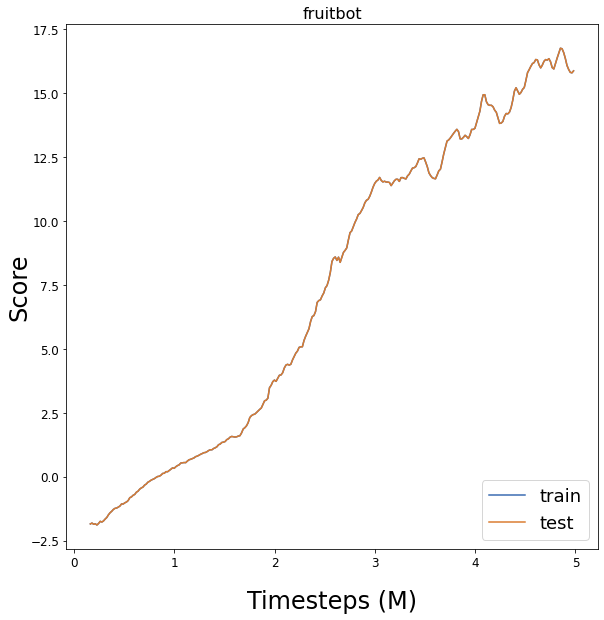

In [ ]:
params = {
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 24,
    'legend.fontsize': 18,
    'figure.figsize': [9, 9]
}
matplotlib.rcParams.update(params)

kwargs = {'smoothing': .9}


kwargs['x_scale'] = 1 * 256 * 64 / 1e6 # num_workers * num_steps_per_rollout * num_envs_per_worker / graph_scaling
num_train_levels = 500
normalization_ranges = EASY_GAME_RANGES


y_label = 'Score'
x_label = 'Timesteps (M)'

kwargs['path'] = target

# We throw out the first few datapoints to give the episodic reward buffers time to fill up
# Otherwise, there could be a short-episode bias
kwargs['first_valid'] = 10

if restrict_training_set:
    kwargs['suffixes'] = ['train', 'test']

if normalize_and_reduce:
    kwargs['normalization_ranges'] = normalization_ranges
    y_label = 'Mean Normalized Score'

fig, axarr = plot(**kwargs)

if normalize_and_reduce:
    axarr.set_xlabel(x_label, labelpad=20)
    axarr.set_ylabel(y_label, labelpad=20)
else:
    ax0 = switch_to_outer_plot(fig)
    ax0.set_xlabel(x_label, labelpad=40)
    ax0.set_ylabel(y_label, labelpad=35)

plt.tight_layout()

plt.savefig(path + '.pdf')